In [17]:
import json
import pickle

from datetime import timedelta, datetime

import pandas as pd
import numpy as np

from create_data import create_data

In [16]:
import darts
from darts.models import NBEATSModel
from darts import TimeSeries

from darts.dataprocessing.transformers import Scaler
from darts.utils.statistics import plot_acf, check_seasonality
from darts.models import ExponentialSmoothing, TBATS, AutoARIMA, Theta
from darts.metrics import mape, mse, mae

In [3]:
params = {
    'start_date': datetime.strptime('2022-09-01', '%Y-%m-%d'),
    'end_date': datetime.strptime('2022-12-01', '%Y-%m-%d'),
    'maintenance_minutes': 10,
    'shift_minutes': 720,
}

data = create_data(params)

terminals = data['terminals']
edge_time = data['edge_time']
balances = data['start_balance']

In [7]:
money = pd.read_excel('input/terminal_data_hackathon v4.xlsx',sheet_name='Start_balance')

In [8]:
df = money.transpose()
df.columns = df.iloc[0]
df = df.iloc[1: , :]
df = df.iloc[1: , :]

df.index = pd.to_datetime(df.index)

df.head(4)

TID,406136,406139,406145,406148,406180,406190,406196,406504,406509,406536,...,699451,699540,699560,699572,699577,699578,699579,699629,699641,699664
2022-09-01,90000,103000,143000,50000,96000,219000,115000,382000,128000,63000,...,47000,80000,110000,124000,0,0,49000,63000,63000,0
2022-09-02,105000,206000,136000,73000,82000,236000,123000,317000,126000,65000,...,61000,102000,57000,0,25000,0,68000,63000,0,0
2022-09-03,99000,168000,124000,53000,71000,218000,121000,479000,170000,0,...,68000,140000,155000,152000,0,10000,0,63000,0,47000
2022-09-04,107000,124000,117000,65000,72000,212000,120000,333000,113000,0,...,76000,78000,192000,161000,0,0,0,64000,51000,0


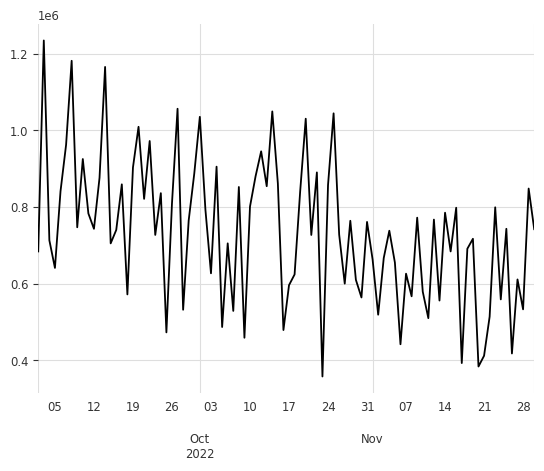

In [10]:
df[605329][1:].plot();

Рассмотрим общий ряд приростов за день по всем терминалам сразу

In [11]:
all_deposits = money.drop(columns=['start_balance']).set_index('TID').sum()
all_deposits.index = pd.to_datetime(all_deposits.index)

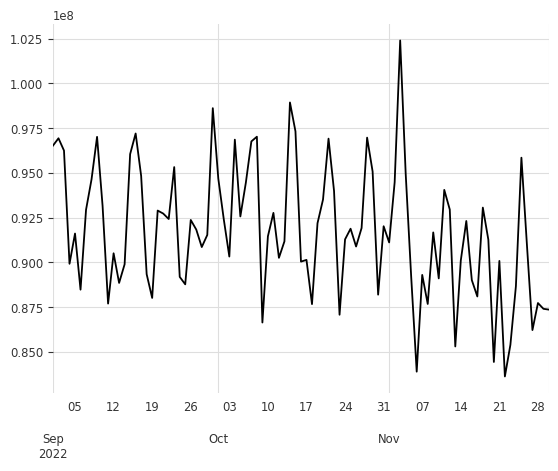

In [12]:
all_deposits.plot();

In [13]:
all_deposits.groupby(by=all_deposits.index.dayofweek).mean()

0    9.037885e+07
1    9.025715e+07
2    9.078569e+07
3    9.311300e+07
4    9.634923e+07
5    9.352823e+07
6    8.768692e+07
dtype: float64

На следующем графике автокорреляционной функции мы видим недельную сезонность

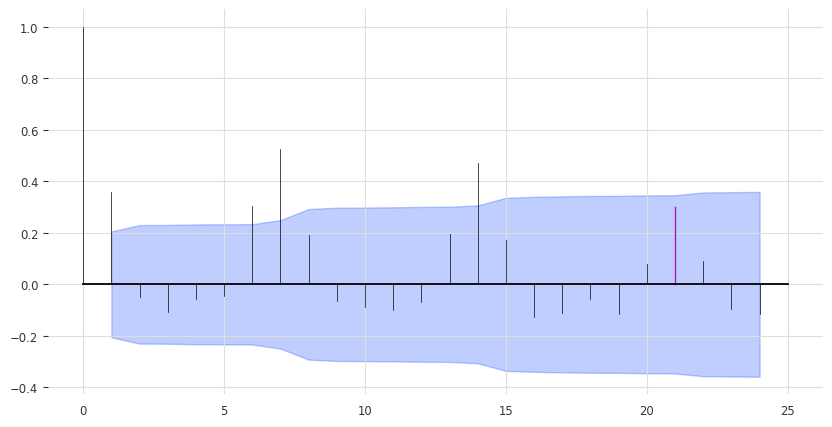

In [15]:
deposits_ts = TimeSeries.from_series(all_deposits)

plot_acf(deposits_ts, m=21, alpha=0.05)

Для предсказания пополнений мы используем модель **N-BEATS** из библиотеки darts свою для каждого терминала:
1. При предсказании мы используем значения пополнений 14-ти предыдущих дней
2. Кроме пополнений самого терминала мы используем в качестве фичи усредненные значения 5-ти ближайших терминалов (не заглядывая в будущее) - это улучшает MAE на 10-15%
3. Мы обучаем модель на первых 70% значений всего ряда
4. Обучение занимает достаточно много времени(около 3ех часов) - поэтому мы сложили модели в файл term_models.pickle - далее в коде есть код загрузки предобученных моделей. term_models - это словарь вида id терминала: модель 

Ссылка на статью, на которой основана имплементация модели: https://openreview.net/forum?id=r1ecqn4YwB

In [129]:
import logging
logging.getLogger("pytorch_lightning.utilities.rank_zero").setLevel(logging.WARNING)
logging.getLogger("pytorch_lightning.accelerators.cuda").setLevel(logging.WARNING)
# отключение логгирования pytorch-lightning

In [ ]:
def build_nbeast_model(term_id): 
    one_term_ts = TimeSeries.from_series(df[term_id])
    logs = {}
    distances = {}
    for term in terminals:
        if term == term_id:
            continue
        distances[term] = edge_time[(term, term_id)]
    top5_terms = [k for k, v in sorted(distances.items(), key=lambda item: item[1], reverse=False)[0:5]]

    covariant_terms = TimeSeries.from_series(pd.concat([df[terminal] for terminal in top5_terms], axis=1).mean(axis=1))

    covariant_train, covariant_test = covariant_terms.split_before(0.7)
    train, test = one_term_ts.split_before(0.7)
    scaler = Scaler()
    cov_scaler = Scaler()
    train_scaled = scaler.fit_transform([train])[0]
    covariant_train_scaled = cov_scaler.fit_transform([covariant_train])[0]
    encoders = {
        "cyclic": {"future": ["month"]},
        "datetime_attribute": {"future": ["dayofweek"]},
        "position": {"past": ["absolute"], "future": ["relative"]},
        "transformer": Scaler(),
    }


    model = NBEATSModel(
        input_chunk_length=14, output_chunk_length=15, random_state=42, batch_size=1024, 
        layer_widths=256, num_stacks=10
    )

    model.fit(
        series=[train_scaled, covariant_train_scaled], 
        epochs=50, 
    )
    pred, cov_pred = model.predict(series=[train_scaled, covariant_train_scaled], n=len(test))
    pred = scaler.inverse_transform(pred)
    pred = pred.map(lambda ts, x: [elem if elem > 0 else 0.0 for elem in x])
    logs['mae'] = mae(test, pred)
    return model, logs

all_logs = {}
term_models = {}
for i, term_id in enumerate(terminals):
    if term_id in term_models:
        continue
    model, logs = build_nbeast_model(term_id)
    term_models[term_id] = model
    all_logs[term_id] = logs
    print(term_id, logs['mae'], i)

In [21]:
with open('predictions/term_models.pickle', 'rb') as fp:
    term_models = pickle.load(fp)

Следующий код строит предсказания ряда для дат, начиная с 14ого сентября и до конца периода предоставленных данных с помощью обученных моделей, и сохраняет их в словарь для всех терминалов на следующие 15 дней. Например для 30 сентября мы строим предсказания для 1-15 октября, не заглядывая в будущее(кроме обучения моделей)
Чтобы посчитать предсказание для новых дат нужно, чтобы просто добавить/заменить в excel файле с приростами данные на исторические за другой период

In [ ]:
prognosis = {}
for i, term in enumerate(terminals):
    model = term_models[term]
    one_term_ts = TimeSeries.from_series(df[term])
    prognosis[term] = {}
    for t in terminals:
        if t == term:
            continue
        distances[t] = edge_time[(t, term)]
    top5_terms = [k for k, v in sorted(distances.items(), key=lambda item: item[1], reverse=False)[0:5]]

    covariant_terms = TimeSeries.from_series(pd.concat([df[terminal] for terminal in top5_terms], axis=1).mean(axis=1))

    covariant_train, covariant_test = covariant_terms.split_before(0.7)
    train, test = one_term_ts.split_before(0.7)
    scaler = Scaler()
    cov_scaler = Scaler()
    train_scaled = scaler.fit_transform([train])[0]
    covariant_train_scaled = cov_scaler.fit_transform([covariant_train])[0]
    scaled_one_term = scaler.transform(one_term_ts)
    scaled_covariant = cov_scaler.transform(covariant_terms)
    for index in range(14, len(scaled_one_term)+1):
        pred, cov_pred = model.predict(series=[scaled_one_term[:index], scaled_covariant[:index]], n=15, verbose=False)
        pred = scaler.inverse_transform(pred)
        pred = pred.map(lambda ts, x: [elem if elem > 0 else 0.0 for elem in x])
        pred_data = json.loads(pred.to_json())
        prognosis[term][str(pred.start_time()-timedelta(days=1))] = {pred_data['index'][i]: pred_data['data'][i][0] 
                                                   for i in range(len(pred_data['index']))}
    print(i, term)

for term in terminals:
    for key in prognosis[term]:
        inner_dict = prognosis[term][key]
        inner_dict = {key_inner.replace('T', ' ')[:-4]: value for key_inner, value in inner_dict.items()}
        prognosis[term][key] = inner_dict

Следующий код добавляет в общий словарь предсказаний - предсказания начального периода 1-14 сентября. Для этих дат нашей модели недостаточно данных(она использует 14 предыдущих дней для предсказания следующих значений) - поэтому здесь мы используем более простую модель: предсказание на каждый день в будущем - это среднее по всем известным предыдущим пополнениям для конкретного терминала.
Отдельный кейс 1 сентября - на этот момент мы ничего не знаем про пополнение, поэтому чтобы получить хоть какой-то адекватный прогноз - просто берем среднее за весь указанный период по терминалу(1 сентября - 30 ноября). Таким образом, мы используем неизвестные на данный моменты данные, но в реальности у нас есть какая-то известная история на этот момент и скорее всего выборочное среднее будет не сильно отличаться от того значения, что мы используем

In [442]:
for term_id in terminals:
    simple_term_progn = {}
    term_avg = df[term_id].mean()
    for i in range(14):
        if i == 0 or df[term_id][:i].mean() == 0:
            prediction = term_avg
        else:
            prediction = df[term_id][:i].mean()
        cur_date = df[term_id].index[i] - timedelta(days=1)
        res_dict = {}
        for j in range(15):
            pred_date = cur_date + timedelta(days=j+1)
            res_dict[str(pred_date)] = prediction
        simple_term_progn[str(cur_date)] = res_dict
    prognosis[term_id].update(simple_term_progn)

Сохраняем все предсказания в словарь

In [444]:
# with open('predictions/prognosis_full_new.pickle', 'wb') as handle:
#     pickle.dump(prognosis, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [54]:
with open('predictions/prognosis_full_new.pickle', 'rb') as fp:
    prognosis = pickle.load(fp)

In [55]:
prognosis[406136]

{'2022-09-14 00:00:00': {'2022-09-15 00:00:00': 101616.5696246644,
  '2022-09-16 00:00:00': 114647.5815534508,
  '2022-09-17 00:00:00': 107828.7113994758,
  '2022-09-18 00:00:00': 121194.8329894619,
  '2022-09-19 00:00:00': 110384.7258403609,
  '2022-09-20 00:00:00': 104249.3225314372,
  '2022-09-21 00:00:00': 94286.0919959654,
  '2022-09-22 00:00:00': 113854.7150604893,
  '2022-09-23 00:00:00': 97174.4470701731,
  '2022-09-24 00:00:00': 107878.0470038326,
  '2022-09-25 00:00:00': 118049.5327671491,
  '2022-09-26 00:00:00': 103003.0431686309,
  '2022-09-27 00:00:00': 91464.7829074257,
  '2022-09-28 00:00:00': 116896.6871889754,
  '2022-09-29 00:00:00': 108374.256905462},
 '2022-09-15 00:00:00': {'2022-09-16 00:00:00': 106362.2834572518,
  '2022-09-17 00:00:00': 108124.0308862128,
  '2022-09-18 00:00:00': 118067.675438982,
  '2022-09-19 00:00:00': 112796.9778616872,
  '2022-09-20 00:00:00': 108114.7780435023,
  '2022-09-21 00:00:00': 111345.8073360434,
  '2022-09-22 00:00:00': 91444.884

Далее приведен пример обучения и предсказания модели для одного из терминалов

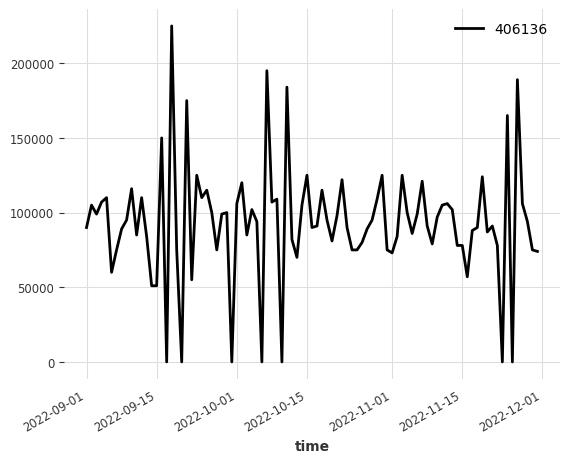

In [45]:
term_id = 406136
one_term_ts = TimeSeries.from_series(df[term_id])
one_term_ts.plot()

In [46]:
corrs = {}
distances = {}
for term in terminals:
    if term == term_id:
        continue
    corrs[term]  = df[term_id].corr(df[term], method='spearman')
    distances[term] = edge_time[(term, term_id)]
top5_terms = [k for k, v in sorted(distances.items(), key=lambda item: item[1], reverse=False)[0:5]]

covariant_terms = TimeSeries.from_series(pd.concat([df[terminal] for terminal in top5_terms], axis=1).mean(axis=1))

covariant_train, covariant_test = covariant_terms.split_before(0.7)

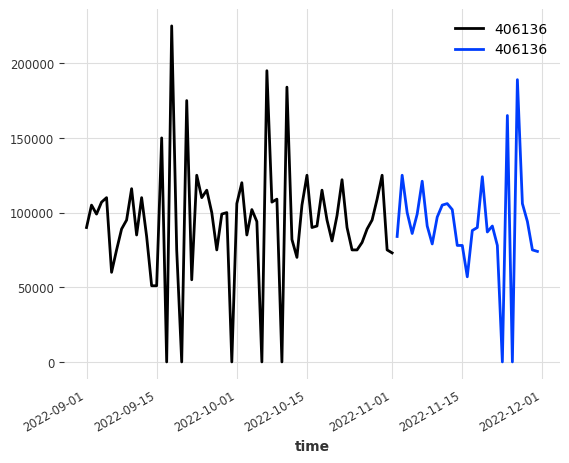

In [47]:
train, test = one_term_ts.split_before(0.7)
train.plot()
test.plot()

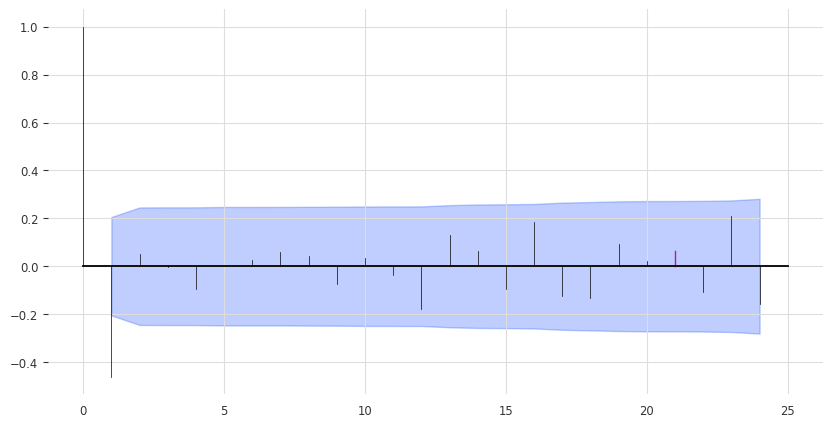

In [48]:
plot_acf(one_term_ts, m=21, alpha=0.05)

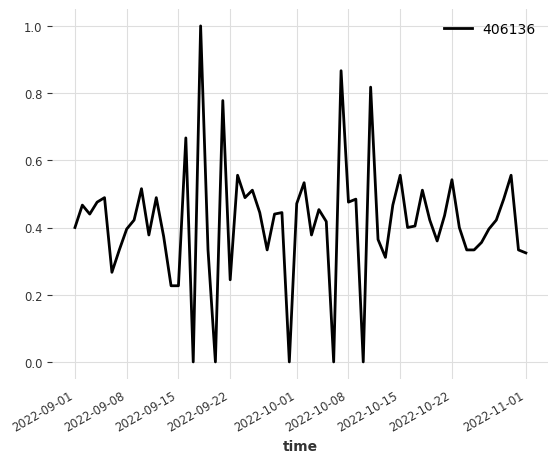

In [49]:
from darts.dataprocessing.transformers import Scaler

scaler = Scaler()
cov_scaler = Scaler()
train_scaled = scaler.fit_transform([train])[0]
covariant_train_scaled = cov_scaler.fit_transform([covariant_train])[0]

train_scaled.plot()

In [50]:
encoders = {
    "cyclic": {"future": ["month"]},
    "datetime_attribute": {"future": ["dayofweek"]},
    "position": {"past": ["absolute"], "future": ["relative"]},
    "transformer": Scaler(),
}


model = NBEATSModel(input_chunk_length=14, output_chunk_length=15, random_state=42, batch_size=1024, 
                    layer_widths=256, num_stacks=10)

model.fit([train_scaled, covariant_train_scaled], 
          epochs=50, verbose=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3070 Ti Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.0 M 
---------------------------------------------------
2.0 M     Trainable params
1.4 K     Non-trainable params
2.0 M     Total params
8.158     To

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


NBEATSModel(generic_architecture=True, num_stacks=10, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=14, output_chunk_length=15, random_state=42, batch_size=1024)

In [51]:
pred, cov_pred = model.predict(series=[train_scaled, covariant_train_scaled], n=len(test))
pred = scaler.inverse_transform(pred)
pred = pred.map(lambda ts, x: [elem if elem > 0 else 0.0 for elem in x])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3070 Ti Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [52]:
mae(test, pred)

29395.23469630657

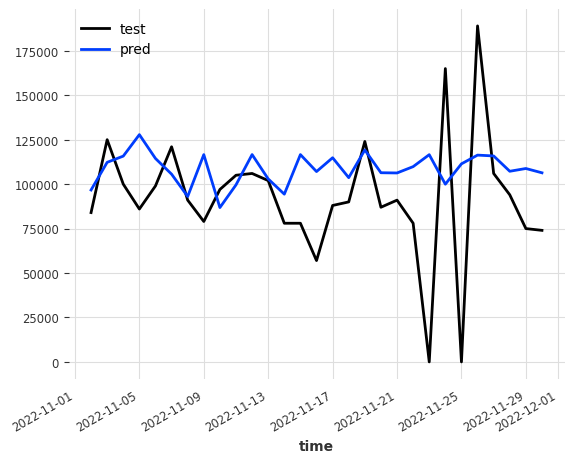

In [53]:
test.plot(label="test")
pred.plot(label="pred")